<a href="https://colab.research.google.com/github/srkwon/analysis/blob/main/data_analysis_20250503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from sklearn.datasets import fetch_openml


# 데이터 수집
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

x = x.values
y = y.astype(int).values



In [35]:
# 데이터 형태 파악(벡터)
x.shape, y.shape

x[:10]

# x.head()

# x.info()

x = ((x / 255.) - .5) * 2

print(type(x))


<class 'numpy.ndarray'>


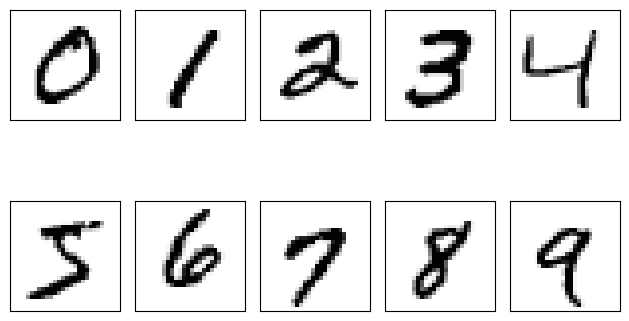

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    img = x[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

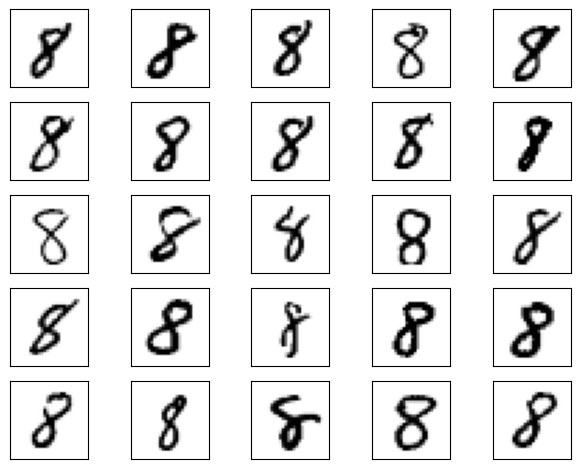

In [44]:
# 8에 해당하는 값만 여러개 출력해보기
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(25):
    img = x[y == 8][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [55]:
from sklearn.model_selection import train_test_split

# 테스트 데이터셋을 1만 건으로 정하고 나머지를 훈련 데이터셋으로 지정
# 훈련/검증/테스트로 나누니까, 일단 테스트를 분리해놓고 훈련 데이터셋을 훈련/검증으로 나누겠다는 것임
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y,  test_size=10000, random_state=123, stratify=y
)

# 기존 훈련 데이터셋을 훈련/검증으로 구분
# 여기서 5만 건이 기존 테스트셋이고 5000건만 검증셋으로 구분하는 식으로 이용
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, y_temp,  test_size=5000, random_state=123, stratify=y_temp
)

# 훈련/검증/테스트 데이터셋 구성 체크
print(f"x_traiin={x_train.shape}, x_valid={x_valid.shape}, x_test={x_test.shape}")




x_traiin=(55000, 784), x_valid=(5000, 784), x_test=(10000, 784)


In [71]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    print(f"shape={y.shape}, num_labels={num_labels}")
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

test = np.ones(3, dtype=int)

int_to_onehot(test, 3)

shape=(3,), num_labels=3


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [78]:
# 코드 샘플 참고 https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.py#L233C1-L288C46

class SimpleMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123) -> None:
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)



